In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("TestSparkSetup").getOrCreate()

In [3]:
print(spark.version)

3.5.5


In [4]:
spark.stop()

Resilient Distributed Datasets - foundation of data processing in pyspark and allow you to work with large datasets across machines

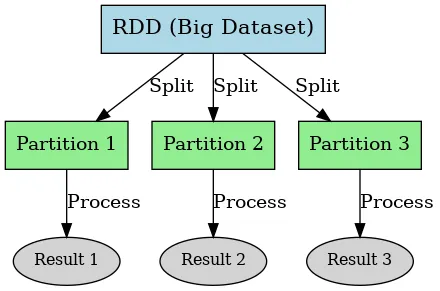

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder.appName("Customer Churn Prediction").getOrCreate()

In [3]:
import os 
os.listdir()

['.git',
 '.gitignore',
 'Churn_Modelling.csv',
 'first.ipynb',
 'pyspark-env',
 'requirements.txt']

In [4]:
data = spark.read.csv("Churn_Modelling.csv",header=True,inferSchema=True)

data.printSchema()
data.show(5)

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+----

In [5]:
#Drop rows with missing values
data_cleaned= data.dropna()

In [11]:
# Convert categorical columns to numerical ones using StringIndexer
from pyspark.ml.feature import StringIndexer

indexer = StringIndexer(inputCol="Gender",outputCol="GenderIndex")
data_indexed = indexer.fit(data_cleaned).transform(data_cleaned)
data_indexed.show(5)
data_indexed=data_indexed.drop("Gender")
data_indexed.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-----------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|GenderIndex|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-----------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|        1.0|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|        1.0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|        1.0|
|        4|  15701354|    Boni|        699|   France|Female| 39|

Need to combine multiple features into a single vector column before training the model

In [13]:
from pyspark.ml.feature import VectorAssembler

#select the features and label column
assembler = VectorAssembler(
    inputCols=["CreditScore","Age","Tenure","Balance","NumOfProducts","IsActiveMember"],
    outputCol="features"
)

#apply the assembler to the dataframe
data_prepared = assembler.transform(data_indexed)

data_prepared.select("features","Exited").show(5)


+--------------------+------+
|            features|Exited|
+--------------------+------+
|[619.0,42.0,2.0,0...|     1|
|[608.0,41.0,1.0,8...|     0|
|[502.0,42.0,8.0,1...|     1|
|[699.0,39.0,1.0,0...|     0|
|[850.0,43.0,2.0,1...|     0|
+--------------------+------+
only showing top 5 rows



In [14]:
from pyspark.ml.classification import LogisticRegression

#Initialize the model
lr = LogisticRegression(featuresCol="features", labelCol="Exited")

model = lr.fit(data_prepared)

predictions=model.transform(data_prepared)

predictions.select("Exited","prediction","probability").show(5)

+------+----------+--------------------+
|Exited|prediction|         probability|
+------+----------+--------------------+
|     1|       0.0|[0.90116189337503...|
|     0|       0.0|[0.86342556143429...|
|     1|       0.0|[0.59878643430133...|
|     0|       0.0|[0.80194824451861...|
|     0|       0.0|[0.84002879162139...|
+------+----------+--------------------+
only showing top 5 rows



In [15]:
#Evaluation

from pyspark.ml.evaluation import BinaryClassificationEvaluator

#initialize 
evaluator = BinaryClassificationEvaluator(labelCol="Exited",metricName="areaUnderROC")

roc_auc= evaluator.evaluate(predictions)
print(f"Area under ROC curve: {roc_auc}")

Area under ROC curve: 0.7462496989173858
